In [1]:
import numpy
import pandas
import matplotlib
import sklearn

%matplotlib inline
from matplotlib import pyplot as plot

from modules.utils import print_versions, unpickle
from modules.transformers import DomainsExtractor
from modules.the_classifier import build_the_classifier

In [2]:
print_versions([ numpy, pandas, matplotlib, sklearn ])

Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
 -  numpy 1.18.1
 -  pandas 1.0.0
 -  matplotlib 3.1.2
 -  sklearn 0.22.1


In [3]:
def impute_domains(sessions, domain_columns, domains):
    sessions_d = sessions[domain_columns].to_numpy().astype('object')

    for r in range(0, sessions_d.shape[0]):
        for c in range(0, sessions_d.shape[1]):
            if numpy.isnan(sessions_d[r, c]):
                sessions_d[r, c] = None
            else:
                sessions_d[r, c] = domains[sessions_d[r, c]]

    sessions[domain_columns] = sessions_d

In [4]:
domains = unpickle('./data/site_dic.pkl')
domains = { value: key for (key, value) in domains.items() }

index_column = 'session_id'
target_column = 'target'
domain_columns = [ 'site{}'.format(i) for i in range(1, 11) ]
time_columns = [ 'time{}'.format(i) for i in range(1, 11) ]

dtype = { c: numpy.float for c in domain_columns }
sessions = pandas.read_csv('./data/train_sessions.csv', index_col=index_column, dtype=dtype, parse_dates=time_columns)
sessions_c = pandas.read_csv('./data/test_sessions.csv', index_col=index_column, dtype=dtype, parse_dates=time_columns)

impute_domains(sessions, domain_columns, domains)
impute_domains(sessions_c, domain_columns, domains)

In [5]:
domains_t = DomainsExtractor().extract(sessions[sessions[target_column] == 1][domain_columns].to_numpy())

In [6]:
X = sessions.loc[:, sessions.columns != target_column].to_numpy()
y = sessions[target_column].to_numpy()

X_time_columns = [ list(sessions.columns).index(column) for column in time_columns ]
X_domain_columns = [ list(sessions.columns).index(column) for column in domain_columns ]

print('Sessions count before split:', X.shape[0])

for (target, count) in zip(y, numpy.bincount(y)):
    print('Sessions with target {} amount to {} of all sessions'.format(target, round(count / X.shape[0], 3)))

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.3, stratify=y, random_state=42)

print()
print('Sessions count in train split:', X_train.shape[0])

for (target, count) in zip(y_train, numpy.bincount(y_train)):
    print('Sessions with target {} amount to {} of all sessions in train split'.format(target, round(count / X_train.shape[0], 3)))

Sessions count before split: 253561
Sessions with target 0 amount to 0.991 of all sessions
Sessions with target 0 amount to 0.009 of all sessions

Sessions count in train split: 177492
Sessions with target 0 amount to 0.991 of all sessions in train split
Sessions with target 0 amount to 0.009 of all sessions in train split


In [7]:
def do_grid_search(classifier, title='', X=X_train, y=y_train, grid_search_kwargs={}):
    grid_search_kwargs_defaults = {
        'scoring' : [ 'f1', 'precision', 'recall', 'roc_auc' ],
        'refit': 'f1',
        'return_train_score': True,

        'cv' : sklearn.model_selection.StratifiedKFold(n_splits=4, shuffle=True, random_state=42),

        'param_grid' : {
        }
    }

    grid_search_kwargs_defaults.update(grid_search_kwargs)
    grid_search_kwargs = grid_search_kwargs_defaults

    grid_search_cv = sklearn.model_selection.GridSearchCV(classifier, **grid_search_kwargs)
    grid_search_cv.fit(X, y)
    
    print('{} CV summary'.format(title.capitalize()))
    print()
    print('Best parameters', grid_search_cv.best_params_)
    print()
    
    for score_name in [ 'f1', 'precision', 'recall', 'roc_auc' ]:
        for score_type in [ 'train', 'test' ]:
            result_key = 'mean_{}_{}'.format(score_type, score_name)

            if score_type == 'test':
                score_type = 'cv test'

            if result_key in grid_search_cv.cv_results_:
                score_value = round(grid_search_cv.cv_results_[result_key][grid_search_cv.best_index_], 5)
                print('Best {} {}: {}'.format(score_type, score_name, score_value))
    
    return grid_search_cv.best_estimator_

In [8]:
def do_test(classifier, title=None, X_test=X_test, y_test=y_test):    
    y_predicted = classifier.predict_proba(X_test)[:, 1]
    
    (precision_y, recall_x, thresholds) = sklearn.metrics.precision_recall_curve(y_test, y_predicted)
    
    score_f1 = lambda p, r: 2 * p * r / (p + r)
    best_f1_index = numpy.argmax([ score_f1(r, p) for (r, p) in zip(recall_x, precision_y) ])
    
    threshold = thresholds[best_f1_index]
    precision = precision_y[best_f1_index]
    recall = recall_x[best_f1_index]
    f1 = score_f1(precision, recall)
    
    roc_auc = sklearn.metrics.roc_auc_score(y_test, y_predicted)
    prc_auc = sklearn.metrics.auc(recall_x, precision_y)
    
    precision_baseline = numpy.mean(y_test)
    
    scores = [ threshold, precision, recall, f1, roc_auc, prc_auc, precision_baseline ]
    [ threshold, precision, recall, f1, roc_auc, prc_auc, precision_baseline ] = [ round(s, 5) for s in scores ]

    print('{} test-control summary'.format(title.capitalize()))
    print()
    print('f1: {}'.format(f1))
    print('precision: {}'.format(precision))
    print('recall: {}'.format(recall))
    print()
    print('roc auc: {}'.format(roc_auc))
    print('prc auc: {}'.format(prc_auc))
    print()
    print('precision baseline: {}'.format(precision_baseline))
    print('optimal f1 threshold: {}'.format(threshold))
    
    if title:
        title = 'Precision recall curve for {}'.format(title.lower())

    plot.plot(recall_x, precision_y, label='Classifier precision recall curve')
    plot.plot(recall_x, [ precision_baseline ] * len(recall_x), label='Precision baseline')
    plot.xlabel('Recall')
    plot.ylabel('Precision')
    plot.legend()
    plot.title(title)
    plot.show()

In [9]:
classifier = build_the_classifier(time_columns=X_time_columns, domain_columns=X_domain_columns, domains=domains_t)

In [10]:
classifier = do_grid_search(classifier, title='The Classifier')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\P

The classifier CV summary

Best parameters {}

Best train f1: 0.99742
Best cv test f1: 0.58826
Best train precision: 0.99485
Best cv test precision: 0.92322
Best train recall: 1.0
Best cv test recall: 0.43346
Best train roc_auc: 1.0
Best cv test roc_auc: 0.98491


The classifier test-control summary

f1: 0.7991
precision: 0.82636
recall: 0.77358

roc auc: 0.98868
prc auc: 0.81323

precision baseline: 0.00906
optimal f1 threshold: 0.11732


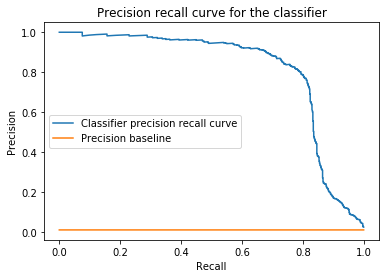

In [11]:
do_test(classifier, title='The Classifier')

In [12]:
classifier = do_grid_search(classifier, title='The Classifier', X=X, y=y, grid_search_kwargs={ 'refit': 'roc_auc' })

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\P

The classifier CV summary

Best parameters {}

Best train f1: 0.99509
Best cv test f1: 0.71455
Best train precision: 0.99023
Best cv test precision: 0.84613
Best train recall: 1.0
Best cv test recall: 0.62557
Best train roc_auc: 1.0
Best cv test roc_auc: 0.98993


In [13]:
y_c = classifier.predict_proba(sessions_c.to_numpy())
targets_c = pandas.DataFrame(y_c[:, 1], sessions_c.index, [ target_column ])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\P

 CV summary

Best parameters {}

Best train f1: 0.99752
Best cv test f1: 0.55534
Best train precision: 0.99505
Best cv test precision: 0.90286
Best train recall: 1.0
Best cv test recall: 0.40423
Best train roc_auc: 1.0
Best cv test roc_auc: 0.98431


In [14]:
targets_c.to_csv('./data/submission.csv')